In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import wandb
import string
import numpy as np
import unicodedata
import pandas as pd
from pathlib import Path
from datasets import load_dataset
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../../src")

import util.preprocessing_util as util

In [3]:
dataset_names = ['covidqa', 'cuad', 'delucionqa', 'emanual', 'expertqa', 'finqa', 'hagrid', 'hotpotqa', 'msmarco', 'pubmedqa', 'tatqa', 'techqa']

# load pubmedqa from RAGBENCH
pubmedqa = load_dataset("rungalileo/ragbench", "pubmedqa")

In [4]:
train_data_raw = pubmedqa['train'].to_pandas()
test_data_raw = pubmedqa['test'].to_pandas()

# Exploration

In [5]:
train_data_raw.head()

,id,question,documents,response,generation_model_name,annotating_model_name,dataset_name,documents_sentences,response_sentences,sentence_support_information,...,trulens_groundedness,trulens_context_relevance,ragas_faithfulness,ragas_context_relevance,gpt3_adherence,gpt3_context_relevance,gpt35_utilization,relevance_score,utilization_score,completeness_score
0,pubmedqa_39085,Is there a functional neural correlate of indi...,[The present study tested whether individuals ...,"Yes, the study mentioned in the first piece of...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, The present study tested whether indivi...","[[a, Yes, the study mentioned in the first pie...",[{'explanation': 'This sentence is directly su...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,0.142857,1.000000
1,pubmedqa_42813,Can we use the Omron T9P automated blood press...,"[Recent events in our hospital, combined with ...","Yes, based on the context provided, we can use...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, Recent events in our hospital, combined...","[[a, Yes, based on the context provided, we ca...",[{'explanation': 'This sentence summarizes the...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454545,0.181818,0.400000
2,pubmedqa_57525,Intraabdominal vascular injury: are we getting...,[Intraabdominal vascular injury (IAVI) as a re...,"Based on the pieces of context provided, the s...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, Intraabdominal vascular injury (IAVI) a...","[[a, Based on the pieces of context provided, ...",[{'explanation': 'This sentence is partially s...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461538,0.307692,0.666667
3,pubmedqa_29863,Hand grip and pinch strength in patients with ...,[The hand grip strength test and pinch was sig...,"Yes, according to the context provided, the ha...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, The hand grip strength test and pinch w...","[[a, Yes, according to the context provided, t...",[{'explanation': 'This sentence is supported b...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.818182,0.181818,0.222222
4,pubmedqa_36126,Is Canada ready for patient accessible electro...,[Access to personal health information through...,"Based on the information provided, Canada is n...",gpt-3.5-turbo-0125,gpt-4o,pubmedqa_train,"[[[0a, Access to personal health information t...","[[a, Based on the information provided, Canada...",[{'explanation': 'The sentence is supported by...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636364,0.454545,0.714286


In [6]:
train_data_raw.shape

(19600, 26)

In [7]:
train_data_raw.columns

Index(['id', 'question', 'documents', 'response', 'generation_model_name',
       'annotating_model_name', 'dataset_name', 'documents_sentences',
       'response_sentences', 'sentence_support_information',
       'unsupported_response_sentence_keys', 'adherence_score',
       'overall_supported_explanation', 'relevance_explanation',
       'all_relevant_sentence_keys', 'all_utilized_sentence_keys',
       'trulens_groundedness', 'trulens_context_relevance',
       'ragas_faithfulness', 'ragas_context_relevance', 'gpt3_adherence',
       'gpt3_context_relevance', 'gpt35_utilization', 'relevance_score',
       'utilization_score', 'completeness_score'],
      dtype='object')

In [16]:
observation = train_data_raw.iloc[18]

In [17]:
observation.question

'Can the life span of human marrow stromal cells be prolonged by bmi-1, E6, E7, and/or telomerase without affecting cardiomyogenic differentiation?'

In [18]:
train_data_raw.all_relevant_sentence_keys

0                                        [0a]
1                        [0a, 1a, 3a, 3b, 4a]
2                    [0a, 0b, 2a, 3c, 3e, 4a]
3        [0a, 0b, 1a, 2a, 2b, 2c, 2d, 2e, 2f]
4                [0a, 0b, 0c, 0d, 1a, 1b, 1c]
                         ...                 
19595        [0a, 0b, 1a, 1b, 2a, 2c, 2d, 3a]
19596                    [0a, 0b, 0c, 0d, 1b]
19597                [0a, 1a, 2a, 3a, 3d, 4c]
19598        [0b, 0c, 0d, 0e, 1a, 1b, 1c, 1d]
19599                [0b, 1a, 1b, 1c, 4a, 4f]
Name: all_relevant_sentence_keys, Length: 19600, dtype: object

In [19]:
for sentence in observation.documents_sentences:
    print(sentence[0][1])

We attempted to prolong the life span of hMSCs by infecting retrovirus encoding bmi-1, human papillomavirus E6 and E7, and/or human telomerase reverse transcriptase genes.
Cell transplantation has recently been challenged to improve cardiac function of severe heart failure.
The potential use of bone marrow stromal cells (MSCs) as a cellular therapy for chronic cardiac diseases relies on the ability of the cell to replicate extensively in vitro and to give rise to myogenic cells that can replace the damaged cardiomyocytes.
Cellular cardiomyoplasty with bone marrow derived stromal (MSC) and mononuclear (BMNC) cells has been shown to improve performance of infarcted hearts.
Some transplanted BMSCs engrafted into myocardial tissue and were positive for cardiac marker troponin T. The hearts containing transplanted BMSCs secreted a larger amount of vascular endothelial growth factor.


# Attributes

In [38]:
relevant_cols = ["question", "documents_sentences", "all_relevant_sentence_keys"]

**Columns**:

- **question:** The medical question being asked. (Used as input)
- **documents_sentences:** Contains the sentences from the source documents. (Context for classification)
- **all_relevant_sentence_keys:**	Identifies which sentences are relevant. (Binary label for classification)

**Goal:**

- Pair each question with its individual document sentences → (question, sentence) pairs.
- Label each sentence as relevant (1) or not relevant (0) → Using all_relevant_sentence_keys.
- Train a classifier using BERT embeddings to classify each sentence.


In [39]:
train_data = train_data_raw[relevant_cols]
test_data = test_data_raw[relevant_cols]

In [40]:
train_data.head()

,question,documents_sentences,all_relevant_sentence_keys
0,Is there a functional neural correlate of indi...,"[[[0a, The present study tested whether indivi...",[0a]
1,Can we use the Omron T9P automated blood press...,"[[[0a, Recent events in our hospital, combined...","[0a, 1a, 3a, 3b, 4a]"
2,Intraabdominal vascular injury: are we getting...,"[[[0a, Intraabdominal vascular injury (IAVI) a...","[0a, 0b, 2a, 3c, 3e, 4a]"
3,Hand grip and pinch strength in patients with ...,"[[[0a, The hand grip strength test and pinch w...","[0a, 0b, 1a, 2a, 2b, 2c, 2d, 2e, 2f]"
4,Is Canada ready for patient accessible electro...,"[[[0a, Access to personal health information t...","[0a, 0b, 0c, 0d, 1a, 1b, 1c]"


In [41]:
print(f"Number of rows: {len(train_data)}")

Number of rows: 19600


# Attribute Transformation

In [42]:
train_data = util.transform_dataset_pubmedQA(train_data_raw)
test_data = util.transform_dataset_pubmedQA(test_data_raw)

In [43]:
print(f"Number of rows: {len(train_data)}")

Number of rows: 237544


**Check Class Imbalance**

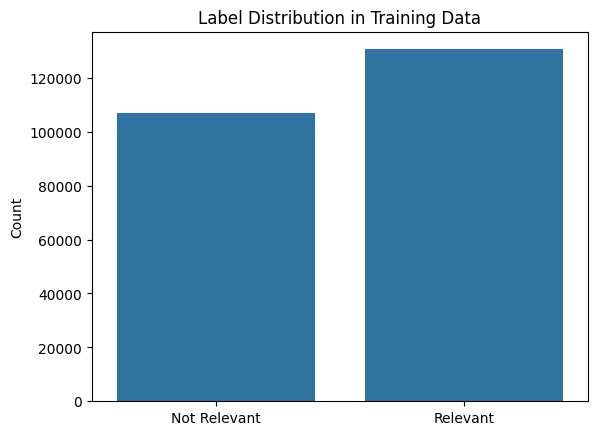

Label counts:
 label
0    106989
1    130555
Name: count, dtype: int64


In [44]:
label_counts = train_data["label"].value_counts().sort_index()
label_names = ["Not Relevant", "Relevant"]

# Plot
sns.barplot(x=label_names, y=label_counts.values)
plt.title("Label Distribution in Training Data")
plt.ylabel("Count")
plt.show()

print("Label counts:\n", label_counts)

# Preprocessing

In [45]:
train_data.dtypes

question    object
sentence    object
label        int64
dtype: object

In [46]:
text_column_names = ("question", "sentence")

In [47]:
train_data = util.clean_text_df(train_data, text_column_names)
test_data = util.clean_text_df(test_data, text_column_names)

Check for missing values

In [48]:
print("---- Train Set ----")
print(train_data.isnull().sum())
print("---- Test Set ----")
print(test_data.isnull().sum())

---- Train Set ----
question    0
sentence    0
label       0
dtype: int64
---- Test Set ----
question    0
sentence    0
label       0
dtype: int64


**Note:** We might want to check for duplicates here

In [49]:
train_data.head()

,question,sentence,label
0,is there a functional neural correlate of indi...,the present study tested whether individuals w...,1
1,is there a functional neural correlate of indi...,this study examined whether heightened cardiov...,0
2,is there a functional neural correlate of indi...,heart rate variability hrv a measure of autono...,0
3,is there a functional neural correlate of indi...,previous studies have also not controlled for ...,0
4,is there a functional neural correlate of indi...,low socioeconomic status is associated with in...,0


Safe if necessary

In [50]:
'''
train_data.to_csv("../../data/dev/processed/pubmedqa_train.csv", index=False)
test_data.to_csv("../../data/dev/processed/pubmedqa_test.csv", index=False)
''';

Aggregate Sentences Per Question

In [51]:
aggregated_train_df = util.aggregate_sentences_by_question(train_data)
aggregated_test_df = util.aggregate_sentences_by_question(test_data)

In [52]:
aggregated_train_df.head()

,question,sentences,labels
0,is there a functional neural correlate of indi...,[the present study tested whether individuals ...,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]"
1,can we use the omron t9p automated blood press...,[recent events in our hospital combined with i...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ..."
2,intraabdominal vascular injury are we getting ...,[intraabdominal vascular injury iavi as a resu...,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, ..."
3,hand grip and pinch strength in patients with ...,[the hand grip strength test and pinch was sig...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ..."
4,is canada ready for patient accessible electro...,[access to personal health information through...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ..."


In [53]:
data_output_dir = Path("../../data/dev/processed/")
data_output_dir.mkdir(parents=True, exist_ok=True)

In [54]:
aggregated_train_df.to_csv(data_output_dir / "pubmedqa_train.csv", index=False)
aggregated_test_df.to_csv(data_output_dir / "pubmedqa_test.csv", index=False)